In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import os
import matplotlib.pyplot as plt
import joblib
from copy import deepcopy
import numpy as np
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from sklearn import feature_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import pandas as pd
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
import random
random_state = 42
import tempfile


In [13]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 
COMET=0
# Create an experiment with your api key
if COMET:
    comet_exp = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
        project_name="milestone_2",
        workspace="morph-e",
        log_code=True,
    )

In [14]:
### Script to get the DataFrame and Split the data into train and test set for FE1
years = [2019]
dataset = SeasonDataSetTwo(years)
df_total = dataset.get_features_2()
df = df_total


File already Exists, loading from ../ift6758/data/PICKLE//2019_features2.pkl


In [15]:
df["Year"]=[str(x)[:4] for x in df['gamePk']]
df["Year"] =df["Year"].astype('int')
df.head()
df

,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,...,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Year
0,2019020001,Ottawa Senators,1,85.0,-1.0,Tip-In,False,False,25.0,25.0,...,Faceoff,0.0,0.0,25.0,85.005882,False,3.400235,0.0,0.0,2019
1,2019020001,Toronto Maple Leafs,1,-32.0,-2.0,Snap Shot,0,True,91.0,91.0,...,Giveaway,-36.0,-31.0,27.0,29.274562,False,1.084243,0.0,0.0,2019
2,2019020001,Ottawa Senators,1,63.0,-6.0,Snap Shot,0,False,203.0,203.0,...,Missed Shot,-64.0,-4.0,14.0,127.015747,False,9.072553,0.0,0.0,2019
3,2019020001,Toronto Maple Leafs,1,-59.0,-20.0,Wrist Shot,0,True,236.0,236.0,...,Takeaway,34.0,-20.0,6.0,93.000000,False,15.500000,0.0,0.0,2019
4,2019020001,Toronto Maple Leafs,1,-42.0,-29.0,Slap Shot,0,True,287.0,287.0,...,Missed Shot,-86.0,4.0,6.0,55.000000,False,9.166667,0.0,0.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76615,2019030416,Tampa Bay Lightning,3,-59.0,-24.0,Snap Shot,0,False,961.0,3361.0,...,Giveaway,64.0,-26.0,3.0,123.016259,False,41.005420,0.0,0.0,2019
76616,2019030416,Tampa Bay Lightning,3,-81.0,3.0,Wrist Shot,0,False,1040.0,3440.0,...,Blocked Shot,-80.0,6.0,2.0,3.162278,False,1.581139,0.0,0.0,2019
76617,2019030416,Dallas Stars,3,34.0,-6.0,Snap Shot,0,True,1130.0,3530.0,...,Takeaway,92.0,-16.0,8.0,58.855756,False,7.356969,0.0,0.0,2019
76618,2019030416,Dallas Stars,3,31.0,10.0,Wrist Shot,0,True,1167.0,3567.0,...,Faceoff,69.0,-22.0,5.0,49.678969,False,9.935794,0.0,0.0,2019


In [16]:
df["emptyNet"] = df["emptyNet"].astype("int")

* Random Forests
* XGBoost with Yearwise Validation
* Kfold CV
* EarlyStopping
* XGBoost Over Sampling
* Removing where emptynet is True events
* Strength in OverTime

In [17]:
df

,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,...,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Year
0,2019020001,Ottawa Senators,1,85.0,-1.0,Tip-In,0,False,25.0,25.0,...,Faceoff,0.0,0.0,25.0,85.005882,False,3.400235,0.0,0.0,2019
1,2019020001,Toronto Maple Leafs,1,-32.0,-2.0,Snap Shot,0,True,91.0,91.0,...,Giveaway,-36.0,-31.0,27.0,29.274562,False,1.084243,0.0,0.0,2019
2,2019020001,Ottawa Senators,1,63.0,-6.0,Snap Shot,0,False,203.0,203.0,...,Missed Shot,-64.0,-4.0,14.0,127.015747,False,9.072553,0.0,0.0,2019
3,2019020001,Toronto Maple Leafs,1,-59.0,-20.0,Wrist Shot,0,True,236.0,236.0,...,Takeaway,34.0,-20.0,6.0,93.000000,False,15.500000,0.0,0.0,2019
4,2019020001,Toronto Maple Leafs,1,-42.0,-29.0,Slap Shot,0,True,287.0,287.0,...,Missed Shot,-86.0,4.0,6.0,55.000000,False,9.166667,0.0,0.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76615,2019030416,Tampa Bay Lightning,3,-59.0,-24.0,Snap Shot,0,False,961.0,3361.0,...,Giveaway,64.0,-26.0,3.0,123.016259,False,41.005420,0.0,0.0,2019
76616,2019030416,Tampa Bay Lightning,3,-81.0,3.0,Wrist Shot,0,False,1040.0,3440.0,...,Blocked Shot,-80.0,6.0,2.0,3.162278,False,1.581139,0.0,0.0,2019
76617,2019030416,Dallas Stars,3,34.0,-6.0,Snap Shot,0,True,1130.0,3530.0,...,Takeaway,92.0,-16.0,8.0,58.855756,False,7.356969,0.0,0.0,2019
76618,2019030416,Dallas Stars,3,31.0,10.0,Wrist Shot,0,True,1167.0,3567.0,...,Faceoff,69.0,-22.0,5.0,49.678969,False,9.935794,0.0,0.0,2019


In [18]:
df.dtypes

gamePk                    object
team.name                 object
gamePeriod                 int64
coordinatesX             float64
coordinatesY             float64
shotType                  object
emptyNet                   int32
isHome                    object
gameSeconds              float64
totalGameSeconds         float64
shotDistance             float64
shotAngle                float64
isGoal                     int64
lastEventType             object
lastEventCoordinatesX    float64
lastEventCoordinatesY    float64
timeFromLastEvent        float64
distanceFromLastEvent    float64
rebound                     bool
speed                    float64
changeInShotAngle        float64
angleSpeed               float64
Year                       int32
dtype: object

## XGBoost Yearwise Validation + EmptyNet:Best Shot Model Test

In [19]:
features = ['gamePk','gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']
df_exp = df[features+label]
print(df_exp.isna().any())
df_exp.head()


gamePk                   False
gameSeconds              False
totalGameSeconds         False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
isHome                    True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
isGoal                   False
dtype: bool


,gamePk,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,isGoal
0,2019020001,25.0,25.0,25.0,1,Tip-In,14.036243,False,85.0,-1.0,4.123106,Faceoff,0.0,0.0,85.005882,False,3.400235,0.0,1
1,2019020001,91.0,91.0,27.0,1,Snap Shot,-2.009554,True,-32.0,-2.0,57.035077,Giveaway,-36.0,-31.0,29.274562,False,1.084243,0.0,0
2,2019020001,203.0,203.0,14.0,1,Snap Shot,12.994617,False,63.0,-6.0,26.683328,Missed Shot,-64.0,-4.0,127.015747,False,9.072553,0.0,0
3,2019020001,236.0,236.0,6.0,1,Wrist Shot,-33.690068,True,-59.0,-20.0,36.055513,Takeaway,34.0,-20.0,93.000000,False,15.500000,0.0,0
4,2019020001,287.0,287.0,6.0,1,Slap Shot,-31.675469,True,-42.0,-29.0,55.226805,Missed Shot,-86.0,4.0,55.000000,False,9.166667,0.0,0


In [20]:
## Removing nan and inf data of features 

remove_nan_inf_features= ["shotAngle","coordinatesX","coordinatesY","shotDistance","lastEventCoordinatesX","lastEventCoordinatesY","distanceFromLastEvent","speed","changeInShotAngle"]
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp["changeInShotAngle"].replace(0,np.nan,inplace=True)


## Converting category features to Category Types
categories = ['shotType','gamePeriod','lastEventType','rebound','isHome']
df_exp[categories]=df_exp[categories].astype("category")


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [46]:
features = ['gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [47]:
dfTestRegular = df_exp[df_exp["gamePk"].astype(str).str[5]=='2']
dfTestPlayoff = df_exp[df_exp["gamePk"].astype(str).str[5]=='3']
Xtest_regular = dfTestRegular[features]
Ytest_regular = dfTestRegular[label]


In [48]:
predscore_val_dict={}

weights_dir = "../ift6758/models/Comet"

Fold 0
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7407
           1       0.27      0.17      0.21       713

    accuracy                           0.89      8120
   macro avg       0.59      0.56      0.57      8120
weighted avg       0.86      0.89      0.87      8120

Fold 1
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7407
           1       0.30      0.22      0.25       713

    accuracy                           0.89      8120
   macro avg       0.61      0.59      0.60      8120
weighted avg       0.87      0.89      0.88      8120

Fold 2
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7407
           1       0.28      0.21      0.24       713

    accuracy                           0.88      8120
   macro avg       0.60      0.58      0.59      8120
weighted avg       0.87      0.88      0.88      8120

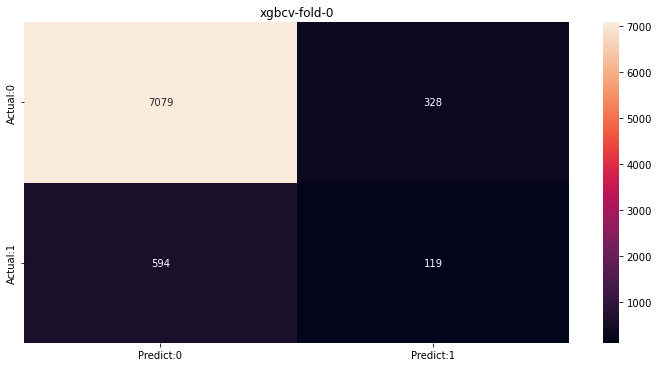

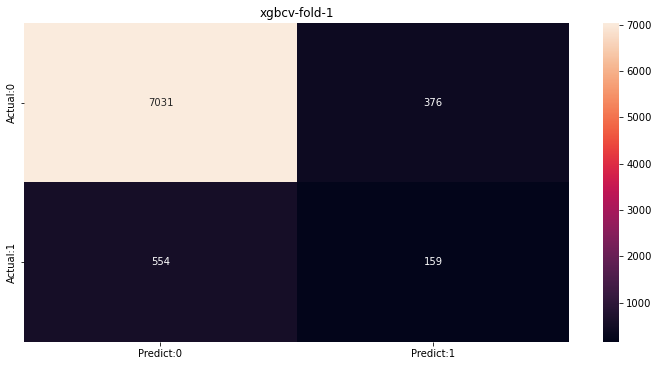

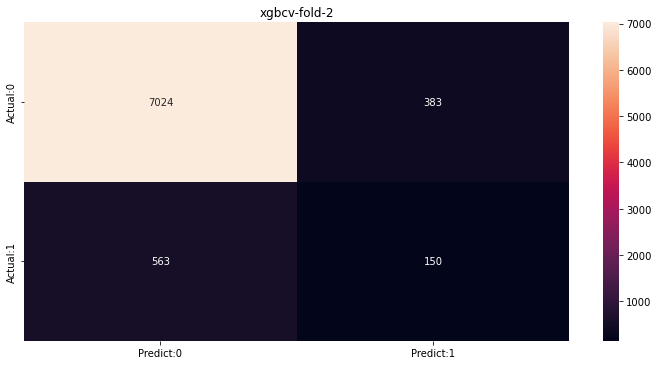

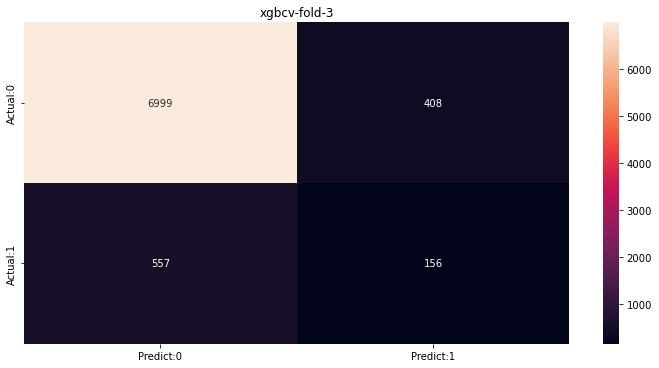

In [49]:
year_list = [2015,2016,2017,2018]
year_partitions= [[2015],[2016],[2017],[2018]]
oof_regular = np.zeros((len(dfTestRegular),2))
oof_playoff= np.zeros((len(dfTestPlayoff),2))

for fold_, (val_yrs) in enumerate(year_partitions):
      # if fold_!=2:
      #     continue
      trn_yrs = list(set(year_list)-set(val_yrs))
      print("Fold {}".format(fold_))

      experiment = f"xgbcv-fold-{fold_}"
      filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
      xgbcv = joblib.load(filename) 
      #     xgb.XGBClassifier(**best_xgb_params)
      #     xgbcv.fit(Xtrain,ytrain)
      y_pred_probs = xgbcv.predict_proba(Xtest_regular)
      y_pred_val = y_pred_probs.argmax(axis=1)
      oof_regular += y_pred_probs/len(year_partitions)
      y_pred_probs = xgbcv.predict_proba(Xtest_playoff)
      y_pred_val = y_pred_probs.argmax(axis=1)
      oof_playoff += y_pred_probs/len(year_partitions)
      plot_metrics.plotConfusion(Ytest_playoff,y_pred_val,title=experiment)



              precision    recall  f1-score   support

           0       0.92      0.95      0.94     61852
           1       0.36      0.24      0.29      6648

    accuracy                           0.89     68500
   macro avg       0.64      0.60      0.61     68500
weighted avg       0.87      0.89      0.87     68500



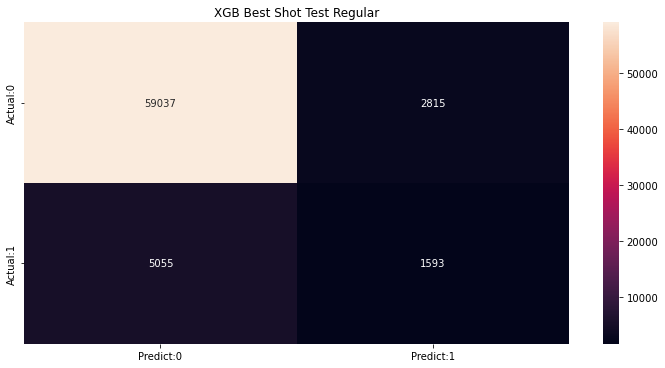

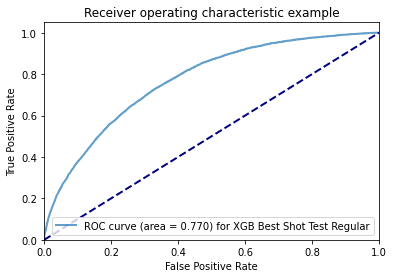

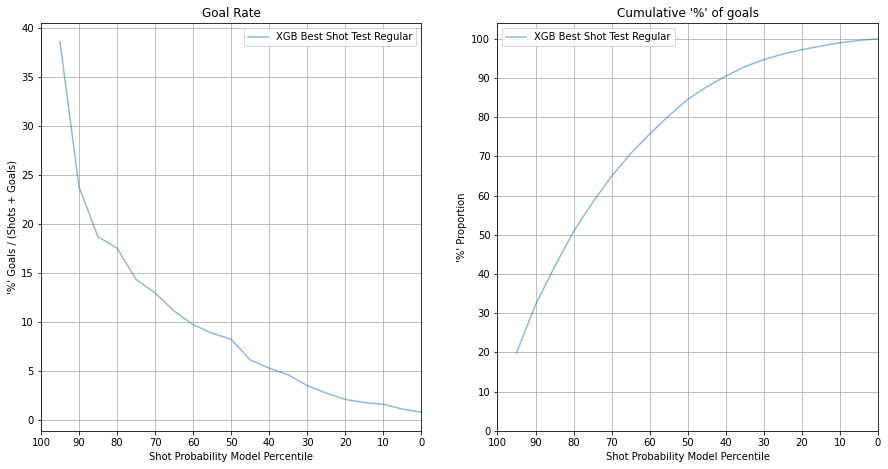

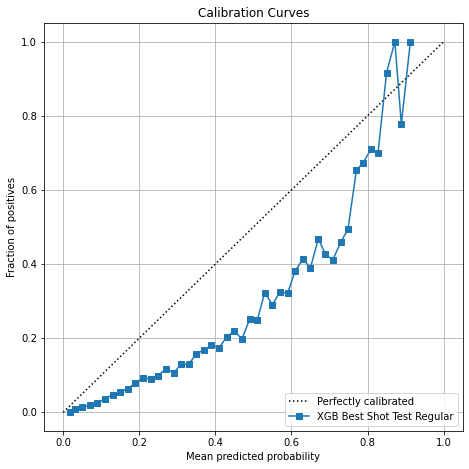

In [50]:
experiment="XGB Best Shot Test Regular"
Yval=Ytest_regular
y_pred_val_scores = oof_regular[:,1]
y_pred_val = oof_regular.argmax(axis=1)
plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)
predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores




## Test Regular on Logreg

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     61852
           1       0.00      0.00      0.00      6648

    accuracy                           0.90     68500
   macro avg       0.45      0.50      0.47     68500
weighted avg       0.82      0.90      0.86     68500



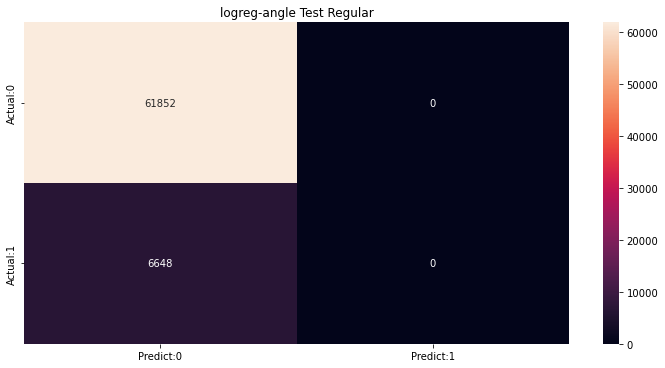

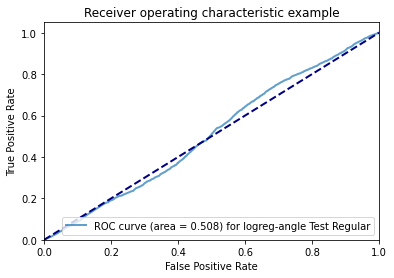

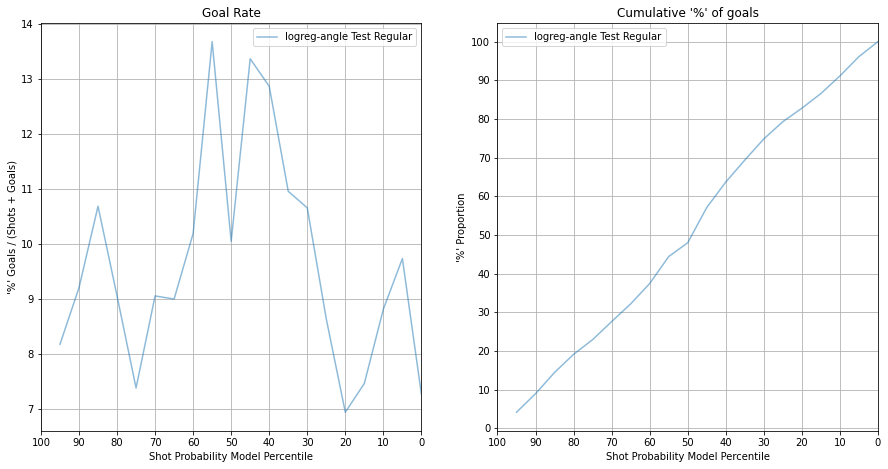

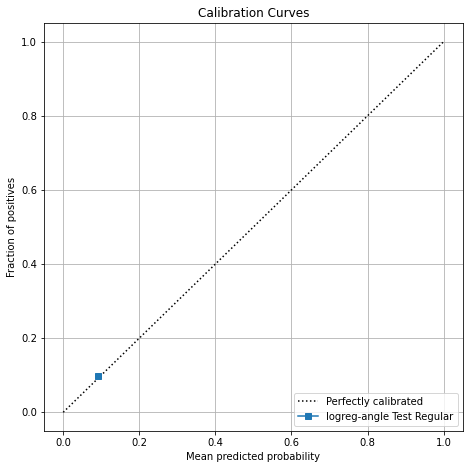

In [51]:
experiment = "logreg-angle Test Regular"
features = ["shotAngle"]
remove_nan_inf_features= features
# df_exp = df_exp[~df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]

label_column = "isGoal"
Xtest = Xtest_regular[features]
Xtest=Xtest.fillna(0)
Ytest = Ytest_regular
filename = f"{weights_dir}/logreg-angle-yearvalidation.pkl"
clf = joblib.load(filename)
y_pred_val  = clf.predict(Xtest)
y_pred_val_scores = clf.predict_proba(Xtest)[:,1]


plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores




C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     61852
           1       0.00      0.00      0.00      6648

    accuracy                           0.90     68500
   macro avg       0.45      0.50      0.47     68500
weighted avg       0.82      0.90      0.86     68500



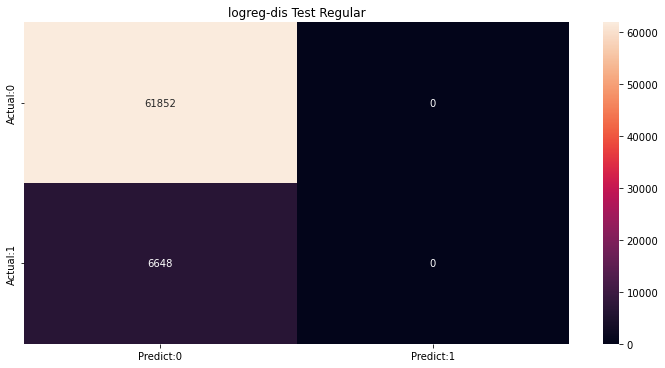

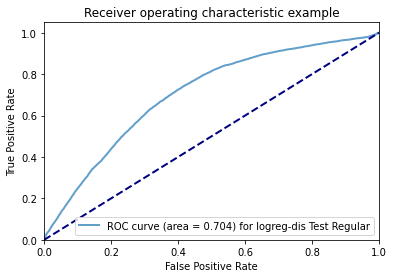

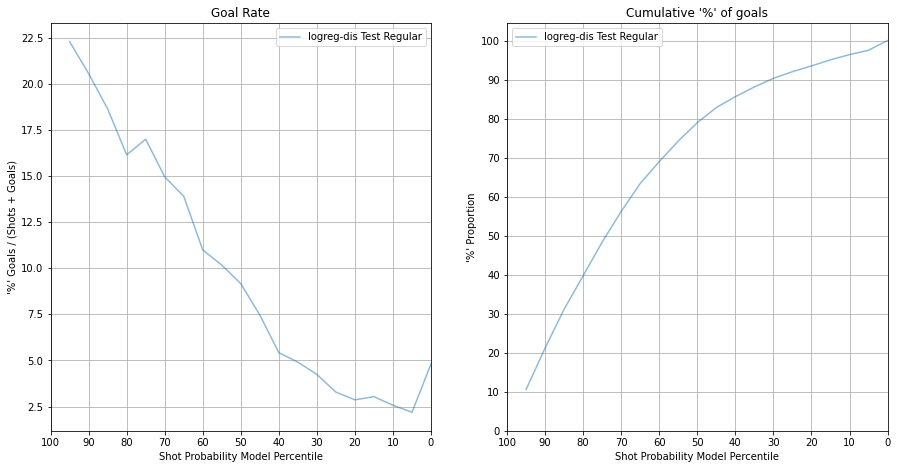

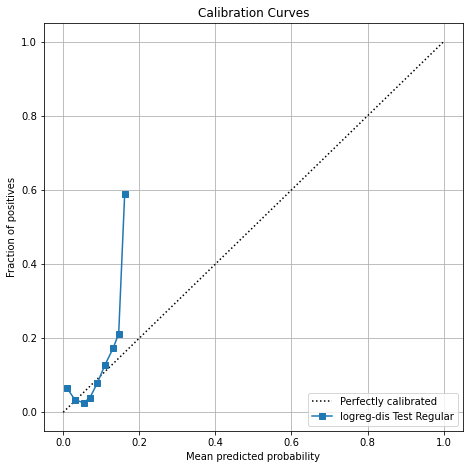

In [52]:
experiment = "logreg-dis Test Regular"
features = ["shotDistance"]
remove_nan_inf_features= features
# df_exp = df_exp[~df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]

label_column = "isGoal"
Xtest = Xtest_regular[features]
Xtest=Xtest.fillna(0)
Ytest = Ytest_regular
filename = f"{weights_dir}/logreg-dis-yearvalidation.pkl"
clf = joblib.load(filename)
y_pred_val  = clf.predict(Xtest)
y_pred_val_scores = clf.predict_proba(Xtest)[:,1]

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores




C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     61852
           1       0.00      0.00      0.00      6648

    accuracy                           0.90     68500
   macro avg       0.45      0.50      0.47     68500
weighted avg       0.82      0.90      0.86     68500



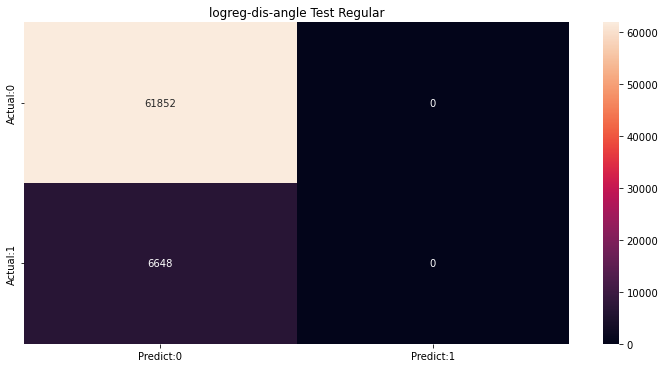

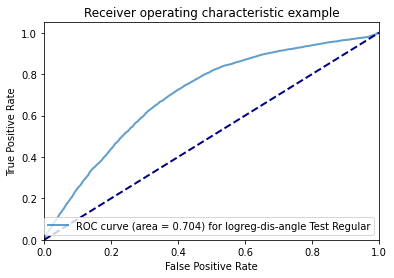

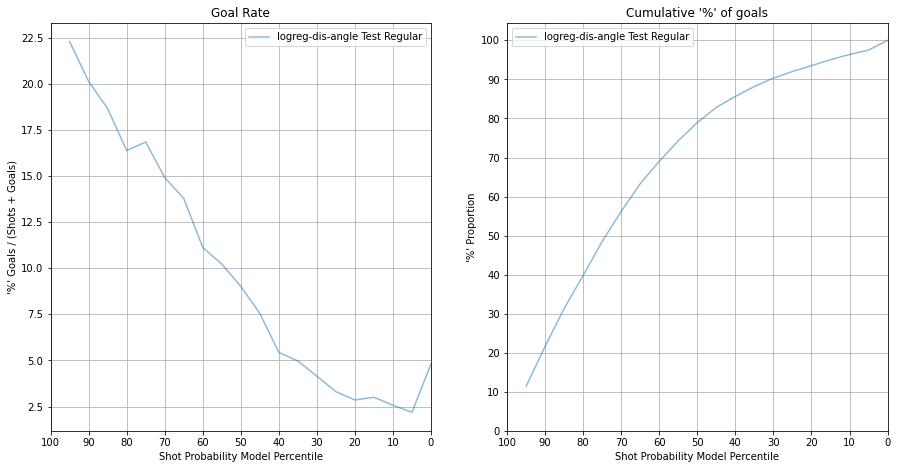

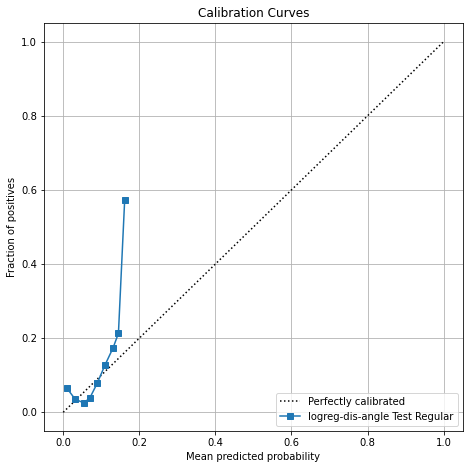

In [53]:
experiment = "logreg-dis-angle Test Regular"
features = ["shotDistance","shotAngle"]
remove_nan_inf_features= features
# df_exp = df_exp[~df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]

label_column = "isGoal"
Xtest = Xtest_regular[features]
Xtest=Xtest.fillna(0)
Ytest = Ytest_regular
filename = f"{weights_dir}/logreg-dis-angle-yearvalidation.pkl"
clf = joblib.load(filename)
y_pred_val  = clf.predict(Xtest)
y_pred_val_scores = clf.predict_proba(Xtest)[:,1]

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)



predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores




              precision    recall  f1-score   support

           0       0.91      0.99      0.95     61852
           1       0.51      0.05      0.09      6648

    accuracy                           0.90     68500
   macro avg       0.71      0.52      0.52     68500
weighted avg       0.87      0.90      0.87     68500



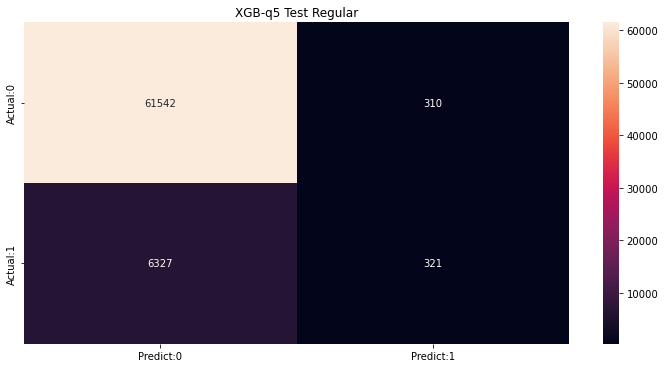

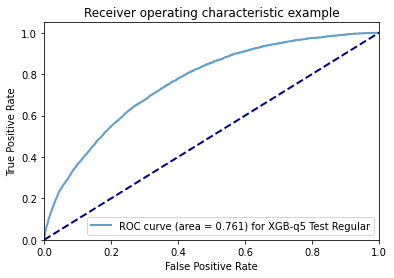

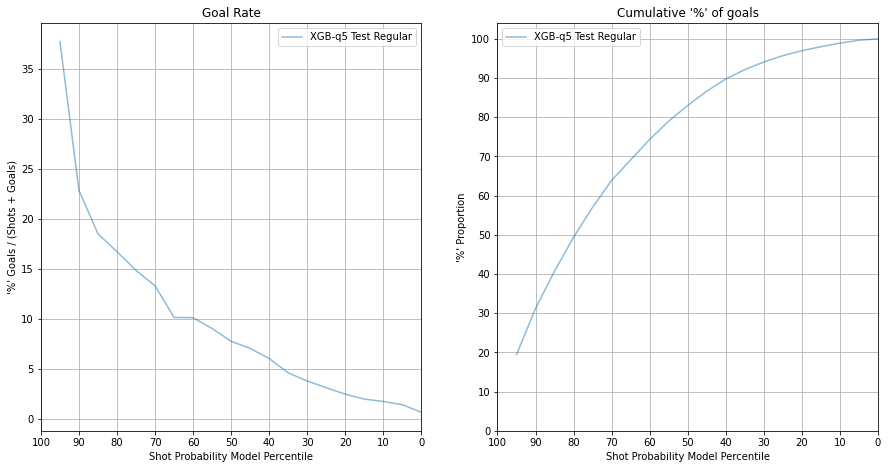

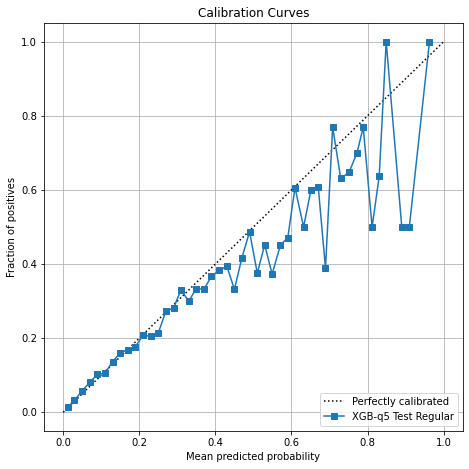

In [54]:
experiment = "XGB-q5 Test Regular"

label_column = "isGoal"
Xtest = Xtest_regular
Ytest = Ytest_regular
filename = f"{weights_dir}/xgbase-bayestuning-allfeatures.pkl"
clf = joblib.load(filename)
y_pred_val  = clf.predict(Xtest)
y_pred_val_scores = clf.predict_proba(Xtest)[:,1]

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)



predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores




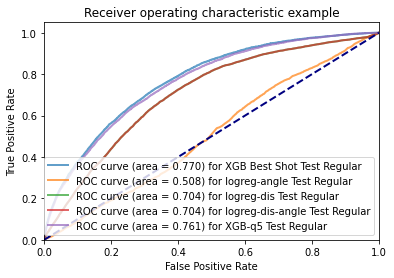

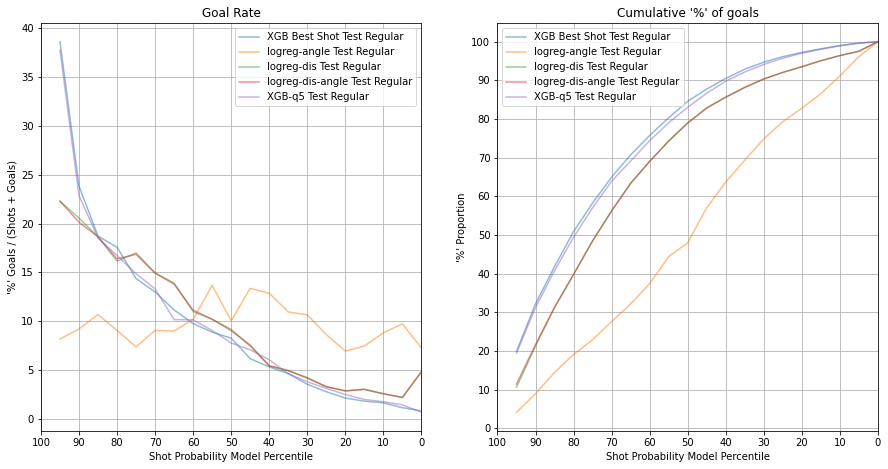

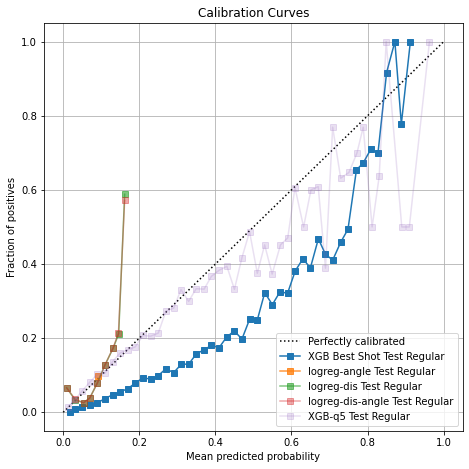

In [56]:
experiments = predscore_val_dict.keys()
Ytrues=[predscore_val_dict[experiment]['val'] for experiment in experiments]
Yscores=[predscore_val_dict[experiment]['predscore'] for experiment in experiments]
plot_labels=experiments
plot_metrics.plot_roc(Ytrues,Yscores,plot_labels)

plot_metrics.plot_percentile(Ytrues,Yscores,plot_labels=plot_labels,bin_width=5)
plot_metrics.plot_calibration(Ytrues,Yscores,plot_labels=plot_labels,n_bins=50)




dict_keys(['Best Shot Test Regular', 'logreg-angle', 'logreg-dis', 'logreg-dis-angle', 'XGB-q5'])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7407
           1       0.29      0.18      0.22       713

    accuracy                           0.89      8120
   macro avg       0.61      0.57      0.58      8120
weighted avg       0.87      0.89      0.88      8120



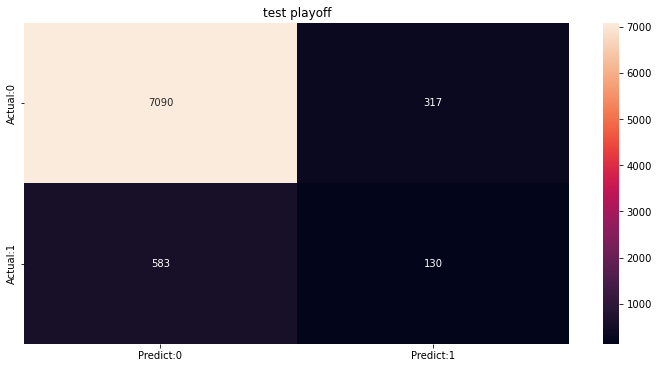

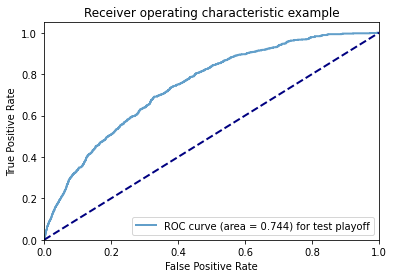

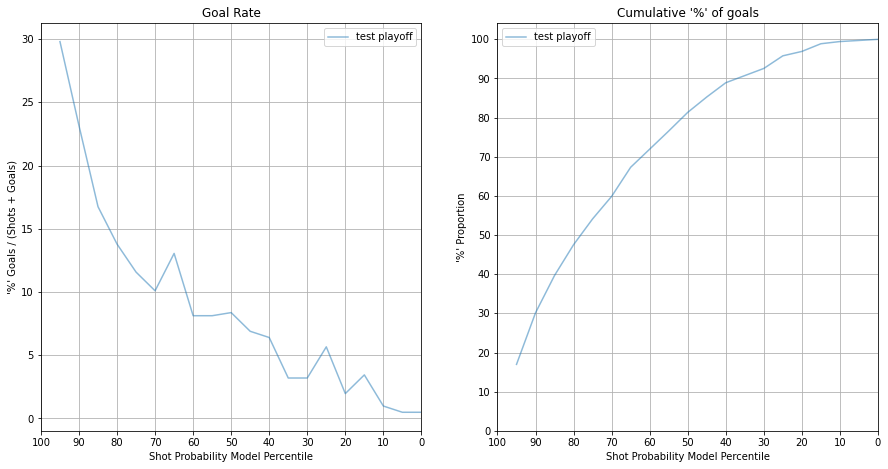

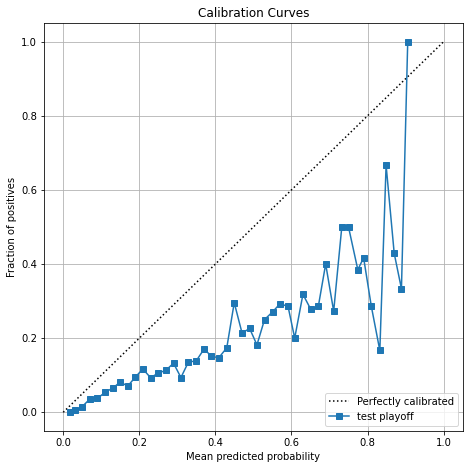

In [26]:
experiment="test playoff"
Yval=Ytest_playoff
y_pred_val_scores = oof_playoff[:,1]
y_pred_val = oof_playoff.argmax(axis=1)
plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)




## Doing Kfold CrossValidation

Fold 0
Train Years [2016, 2017, 2018] Data Points 237314
Val Years [2015]  Data Points 73792           Val ratio 0.23719246816197695
(73792, 1) (73792,)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     66989
           1       0.35      0.23      0.27      6803

    accuracy                           0.89     73792
   macro avg       0.64      0.59      0.61     73792
weighted avg       0.87      0.89      0.88     73792

Fold 1
Train Years [2017, 2018, 2015] Data Points 236143
Val Years [2016]  Data Points 74963           Val ratio 0.2409564585703908
(74963, 1) (74963,)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     68035
           1       0.35      0.24      0.29      6928

    accuracy                           0.89     74963
   macro avg       0.64      0.60      0.61     74963
weighted avg       0.87      0.89      0.88     74963

Fold 2
Train Years [2016, 2018, 2015] Dat

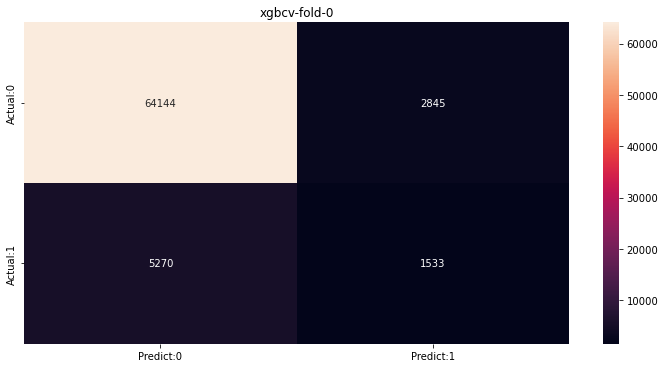

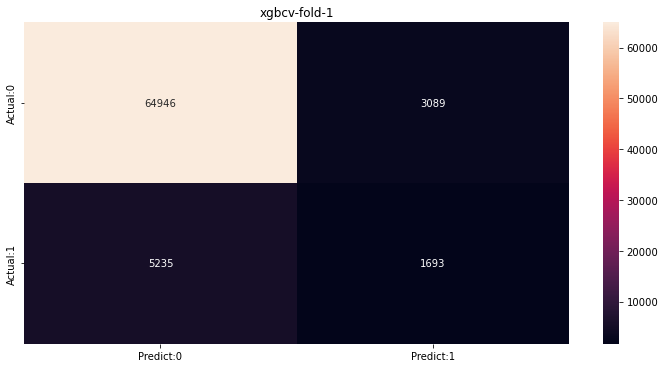

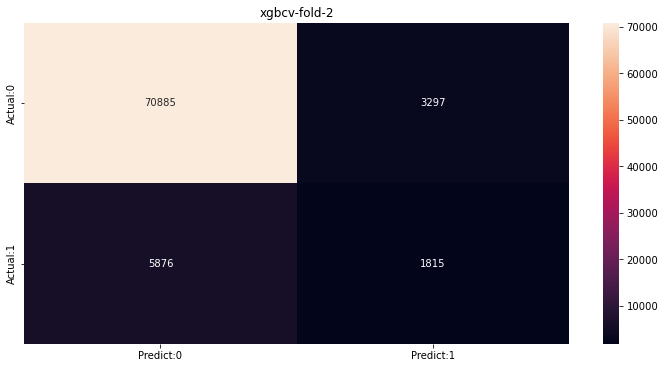

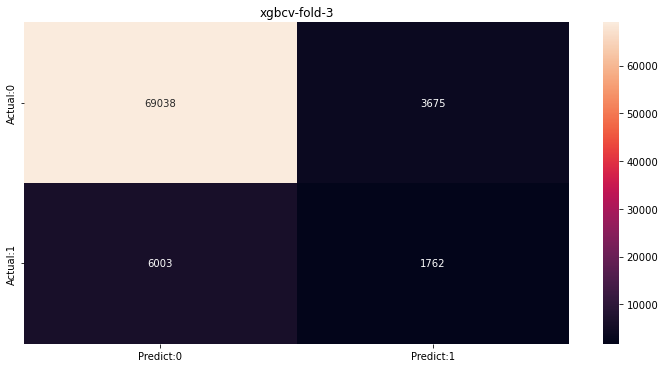

In [151]:
year_list = [2015,2016,2017,2018]
year_partitions= [[2015],[2016],[2017],[2018]]
oof = np.zeros((len(df_exp),2))

for fold_, (val_yrs) in enumerate(year_partitions):
    # if fold_!=2:
    #     continue
    trn_yrs = list(set(year_list)-set(val_yrs))
    print("Fold {}".format(fold_))

    
    trn_ids= df_exp.loc[df_exp["Year"].isin(trn_yrs)].index
    trn_idx = trn_ids.to_numpy()
    val_idx = df_exp.loc[df_exp["Year"].isin(val_yrs)].index
    np.random.shuffle(trn_idx) ##Shuffling
    print(f"Train Years {trn_yrs} Data Points {trn_idx.shape[0]}")
    print(f"Val Years {val_yrs}  Data Points {val_idx.shape[0]} \
          Val ratio {val_idx.shape[0]/(val_idx.shape[0]+trn_idx.shape[0])}")

    Xtrain, Xval = df_exp.iloc[trn_idx][features], df_exp.iloc[val_idx][features]
    ytrain, yval = df_exp.iloc[trn_idx][label], df_exp.iloc[val_idx][label],
    best_xgb_params=clf.best_estimator_.get_params()
    xgbcv = xgb.XGBClassifier(**best_xgb_params)
    xgbcv.fit(Xtrain,ytrain)
    y_pred_probs = xgbcv.predict_proba(Xval)
    y_pred_val = y_pred_probs.argmax(axis=1)
    oof[val_idx] = y_pred_probs
    print(yval.shape,y_pred_val.shape)
    experiment = f"xgbcv-fold-{fold_}"
    filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
    joblib.dump(xgbcv,filename)

    plot_metrics.plotConfusion(yval,y_pred_val,title=experiment)



In [146]:
a=[1,2,3]
np.random.shuffle(a)

In [147]:
a

[2, 1, 3]

In [138]:
val_idx.to_numpy()

array([    0,     1,     2, ..., 73789, 73790, 73791], dtype=int64)

In [113]:
bp

OrderedDict([('gamma', 0.2),
             ('learning_rate', 0.15),
             ('max_depth', 6),
             ('n_estimators', 65),
             ('reg_alpha', 0.1),
             ('reg_lambda', 51.2)])

              precision    recall  f1-score   support

           0       0.92      0.95      0.94    281919
           1       0.35      0.23      0.28     29187

    accuracy                           0.89    311106
   macro avg       0.63      0.59      0.61    311106
weighted avg       0.87      0.89      0.88    311106



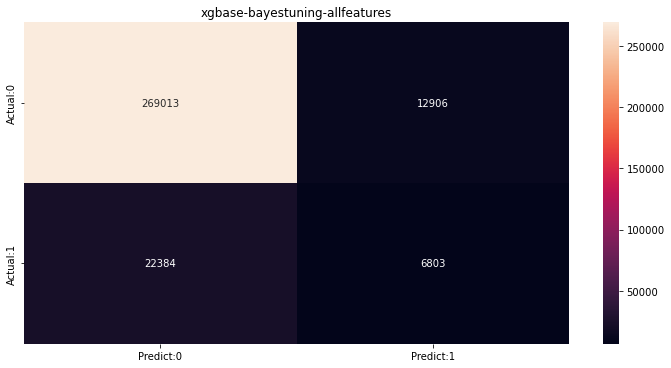

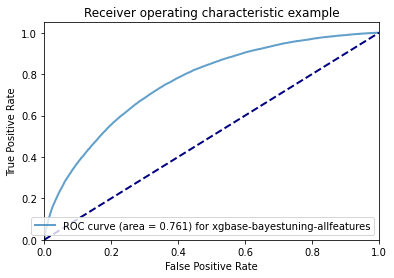

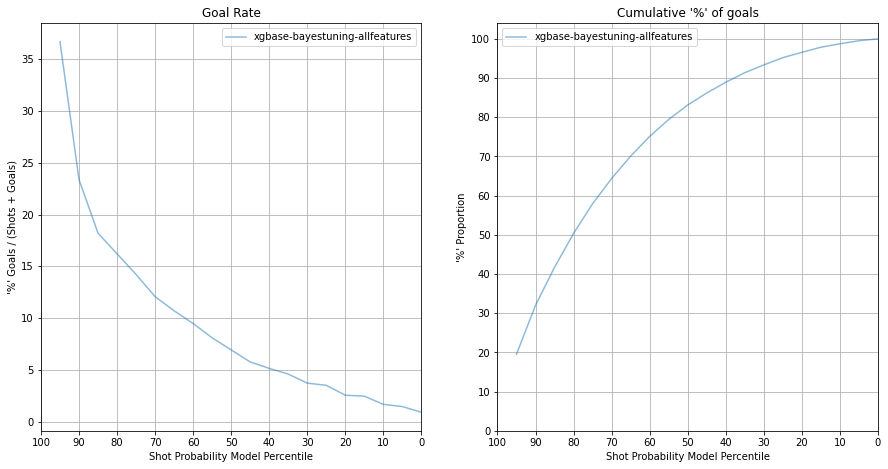

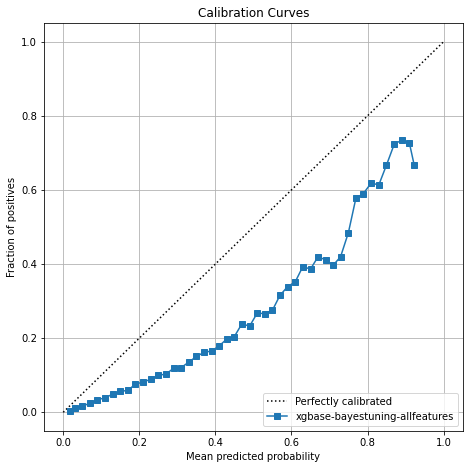

In [129]:

Yval=df_exp[label]
y_pred_val_scores = oof[:,1]
y_pred_val = oof.argmax(axis=1)
plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)


